<a href="https://colab.research.google.com/github/yadonnn/foodclassification/blob/main/efficientnetfoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unin

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [ ]:
from multiprocessing import cpu_count

num_cpus = cpu_count()
num_cpus

2

In [ ]:
!rm -d food
!mkdir food
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/archive.zip' -d '/content/food'

rm: cannot remove 'food': No such file or directory


101000 files and 101 classes
Mean=1000, Median=1000, StdDev=0.0
Max=1000, Min=1000
percentile = Q1 : 1000.0, Q2 : 1000.0, Q3 : 1000.0
lower_bound = 1000.0, upper_bound = 1000.0
outlier = {}


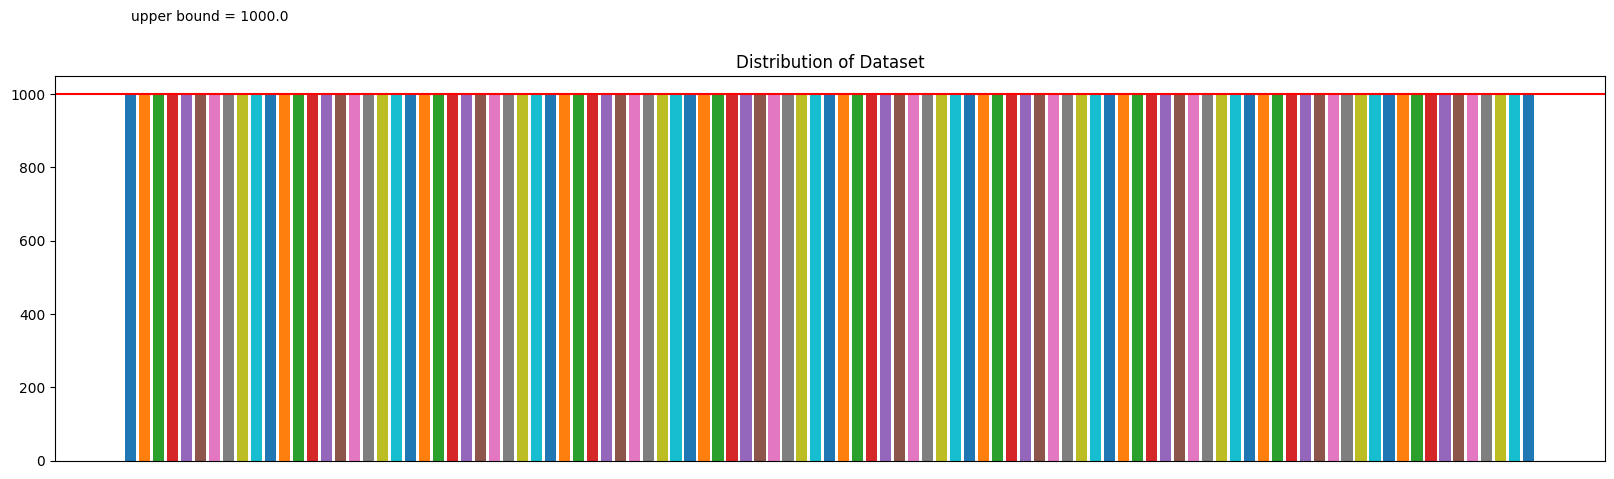

In [ ]:
import os, pathlib, statistics
import matplotlib.pyplot as plt
import numpy as np

def counts(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                class_names = file_path.split(os.sep)[-2]

                if class_names in class_counts:
                    class_counts[class_names] += 1

                else:
                    class_counts[class_names] = 1
    return class_counts


def stats_data_from_dictionary(dictionary):
    mean = statistics.mean(dictionary.values())
    median = statistics.median(dictionary.values())
    stdev = statistics.stdev(dictionary.values())
    sorted_dictionary = np.sort(list(dictionary.values()))
    Q1 = np.percentile(sorted_dictionary, 25)
    Q2 = np.percentile(sorted_dictionary, 50)
    Q3 = np.percentile(sorted_dictionary, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outlier = {}
    plt.figure(figsize=(20, 5))

    for names, counts in dictionary.items():
        if counts < lower_bound or counts > upper_bound:
            outlier[names] = counts
        plt.bar(names, counts)
        plt.gca().axes.xaxis.set_visible(False)
    plt.title('Distribution of Dataset')
    plt.axhline(upper_bound, color='r')
    plt.text(0, upper_bound+200, f'upper bound = {upper_bound}')

    print(f"{sum(dictionary.values())} files and {len(dictionary)} classes")
    print(f"Mean={mean}, Median={median}, StdDev={stdev}\nMax={max(dictionary.values())}, Min={min(dictionary.values())}")
    print(f"percentile = Q1 : {Q1}, Q2 : {Q2}, Q3 : {Q3}")
    print(f"lower_bound = {lower_bound}, upper_bound = {upper_bound}\noutlier = {outlier}")

dir = '/content/food/images'
counts_dictionary = counts(dir)
stats_data_from_dictionary(counts_dictionary)

In [ ]:
import shutil
def filter_counts(directory, minpops):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                class_names = file_path.split(os.sep)[-2]

                if class_names in class_counts:
                    class_counts[class_names] += 1

                else:
                    class_counts[class_names] = 1
    class_counts = {key : value for key, value in class_counts.items() if value > minpops}
    return class_counts

def moving(dir, to_dir, class_counts):
    if not os.path.isdir(to_dir):
        os.mkdir(to_dir)

    for folder in os.listdir(dir):
        if folder not in class_counts.keys():
            remove_folder = os.path.join(dir , folder)
            shutil.move(remove_folder, to_dir)
    return print('moved successed')


In [ ]:
min500 = filter_counts(dir, 500)
to_dir = '/content/moved'
moving(dir, to_dir,min500)

moved successed


In [ ]:
counts_dictionary = counts(dir)
stats_data_from_dictionary(counts_dictionary)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
dir = '/content/food/images'
batch_size = 256
image_size = (224, 224)

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
    rotation_range=10,
    shear_range=0.2,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = data_generator.flow_from_directory(
    dir,
    subset='training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = data_generator.flow_from_directory(
    dir,
    subset='validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 85850 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math, os
from keras.applications.efficientnet import EfficientNetB0
K.clear_session()

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(train_generator.num_classes, kernel_regularizer=l2(.0005), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model_type = 'efficientnet_foods101'
save_dir = f'/content/drive/MyDrive/foodmodel'
model_dir = os.path.join(save_dir , f'{model_type}_model.h5')
history_dir = os.path.join(save_dir , f'{model_type}_history.pkl')
checkpoint_dir = os.path.join(save_dir , f'{model_type}_checkpoint.h5')
checkpoint = ModelCheckpoint(checkpoint_dir, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import pickle
history = model.fit_generator(train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        epochs=20,
        callbacks=[lr_scheduler, checkpoint],
        use_multiprocessing=True,
        workers=num_cpus)


with open(history_dir, 'wb')as f:
  pickle.dump(history.history, f)

model.save(model_dir)

<ipython-input-5-5a0c904d67a3>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
335/335 [==============================] - 464s 1s/step - loss: 3.1411 - accuracy: 0.3217 - val_loss: 1.7297 - val_accuracy: 0.5901 - lr: 0.0100
Epoch 2/20
335/335 [==============================] - 444s 1s/step - loss: 1.6084 - accuracy: 0.6149 - val_loss: 1.3216 - val_accuracy: 0.6815 - lr: 0.0100
Epoch 3/20
335/335 [==============================] - 451s 1s/step - loss: 1.3006 - accuracy: 0.6871 - val_loss: 1.1790 - val_accuracy: 0.7124 - lr: 0.0100
Epoch 4/20
335/335 [==============================] - 450s 1s/step - loss: 1.1441 - accuracy: 0.7250 - val_loss: 1.0838 - val_accuracy: 0.7366 - lr: 0.0100
Epoch 5/20
335/335 [==============================] - 448s 1s/step - loss: 1.0371 - accuracy: 0.7514 - val_loss: 1.0430 - val_accuracy: 0.7461 - lr: 0.0100
Epoch 6/20
335/335 [==============================] - 444s 1s/step - loss: 0.9569 - accuracy: 0.7701 - val_loss: 0.9902 - val_accuracy: 0.7599 - lr: 0.0100
Epoch 7/20
335/335 [==============================] - 448s 1s/st

In [ ]:
!rm -d foodval
!mkdir foodval
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/transformed_validation.zip' -d '/content/foodval'

rm: cannot remove 'foodval': No such file or directory


299348 files and 570 classes
Mean=525.1719298245614, Median=475.5, StdDev=383.8629642321577
Max=2231, Min=4
percentile = Q1 : 184.5, Q2 : 475.5, Q3 : 781.0
lower_bound = -710.25, upper_bound = 1675.75
outlier = {'춘권': 1750, '스프': 1785, '다크초콜릿': 2231, '청포도': 1904, '소시지구이': 1804}


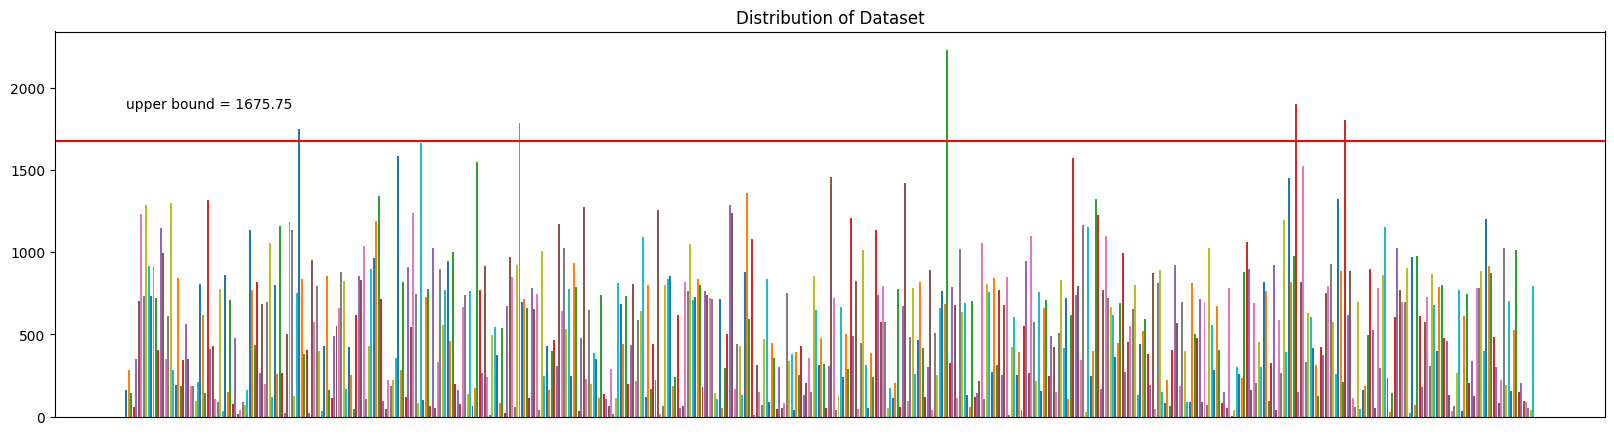

In [ ]:
import os, pathlib, statistics
import matplotlib.pyplot as plt
import numpy as np

def counts(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                class_names = file_path.split(os.sep)[-2]

                if class_names in class_counts:
                    class_counts[class_names] += 1

                else:
                    class_counts[class_names] = 1
    return class_counts


def stats_data_from_dictionary(dictionary):
    mean = statistics.mean(dictionary.values())
    median = statistics.median(dictionary.values())
    stdev = statistics.stdev(dictionary.values())
    sorted_dictionary = np.sort(list(dictionary.values()))
    Q1 = np.percentile(sorted_dictionary, 25)
    Q2 = np.percentile(sorted_dictionary, 50)
    Q3 = np.percentile(sorted_dictionary, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outlier = {}
    plt.figure(figsize=(20, 5))

    for names, counts in dictionary.items():
        if counts < lower_bound or counts > upper_bound:
            outlier[names] = counts
        plt.bar(names, counts)
        plt.gca().axes.xaxis.set_visible(False)
    plt.title('Distribution of Dataset')
    plt.axhline(upper_bound, color='r')
    plt.text(0, upper_bound+200, f'upper bound = {upper_bound}')

    print(f"{sum(dictionary.values())} files and {len(dictionary)} classes")
    print(f"Mean={mean}, Median={median}, StdDev={stdev}\nMax={max(dictionary.values())}, Min={min(dictionary.values())}")
    print(f"percentile = Q1 : {Q1}, Q2 : {Q2}, Q3 : {Q3}")
    print(f"lower_bound = {lower_bound}, upper_bound = {upper_bound}\noutlier = {outlier}")

dir = '/content/foodval'
counts_dictionary = counts(dir)
stats_data_from_dictionary(counts_dictionary)

In [ ]:
import shutil
def filter_counts(directory, minpops):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                class_names = file_path.split(os.sep)[-2]

                if class_names in class_counts:
                    class_counts[class_names] += 1

                else:
                    class_counts[class_names] = 1
    class_counts = {key : value for key, value in class_counts.items() if value > minpops}
    return class_counts

def moving(dir, to_dir, class_counts):
    if not os.path.isdir(to_dir):
        os.mkdir(to_dir)

    for folder in os.listdir(dir):
        if folder not in class_counts.keys():
            remove_folder = os.path.join(dir , folder)
            shutil.move(remove_folder, to_dir)
    return print('moved successed')


In [ ]:
min100 = filter_counts(dir, 100)
to_dir = '/content/moved'
moving(dir, to_dir,min100)

moved successed


295061 files and 491 classes
Mean=600.938900203666, Median=591, StdDev=359.86946660405914
Max=2231, Min=101
percentile = Q1 : 291.5, Q2 : 591.0, Q3 : 811.5
lower_bound = -488.5, upper_bound = 1591.5
outlier = {'춘권': 1750, '코코아': 1662, '스프': 1785, '다크초콜릿': 2231, '청포도': 1904, '소시지구이': 1804}


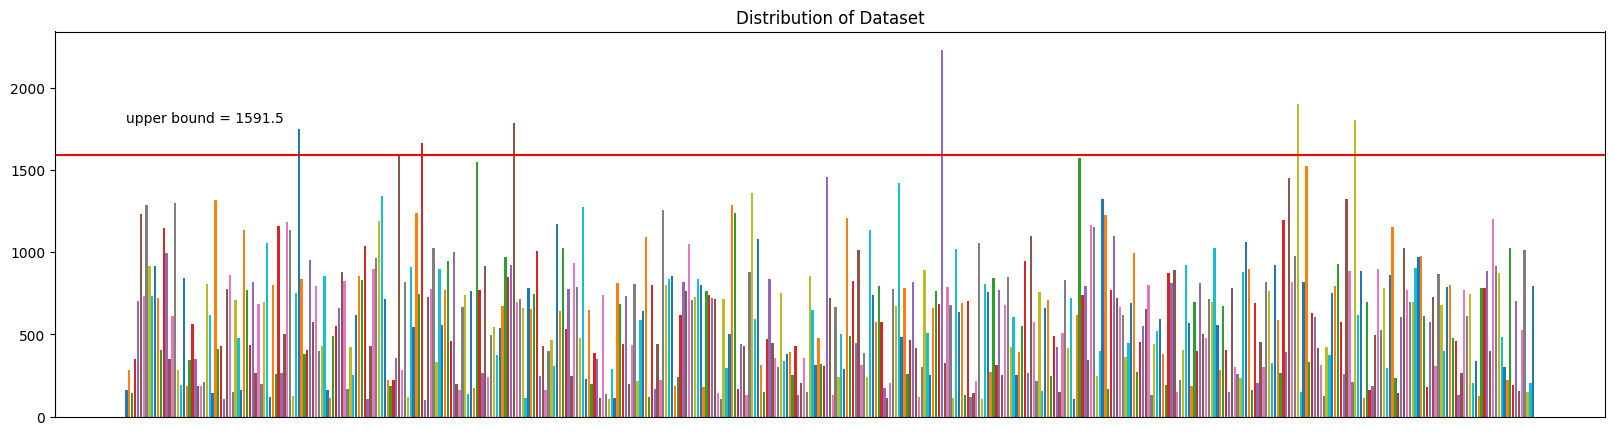

In [ ]:
counts_dictionary = counts(dir)
stats_data_from_dictionary(counts_dictionary)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
dir = '/content/foodval'
batch_size = 256
image_size = (224, 224)

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
    rotation_range=10,
    shear_range=0.2,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = data_generator.flow_from_directory(
    dir,
    subset='training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = data_generator.flow_from_directory(
    dir,
    subset='validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 251033 images belonging to 491 classes.
Found 44031 images belonging to 491 classes.


In [ ]:
with open('/content/drive/MyDrive/foodmodel/class_names.pkl', 'wb')as f:
  pickle.dump(train_generator.class_indices, f)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math, os
from keras.applications.efficientnet import EfficientNetB0
K.clear_session()

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(train_generator.num_classes, kernel_regularizer=l2(.0005), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def schedule(epoch):
    if epoch < 15:
        return .01
    else:
        return .002
lr_scheduler = LearningRateScheduler(schedule)

model_type = 'efficientnet_foodsval'
save_dir = f'/content/drive/MyDrive/foodmodel'
model_dir = os.path.join(save_dir , f'{model_type}_model.h5')
history_dir = os.path.join(save_dir , f'{model_type}_history.pkl')
checkpoint_dir = os.path.join(save_dir , f'{model_type}_checkpoint.h5')
checkpoint = ModelCheckpoint(checkpoint_dir, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
import pickle
history = model.fit_generator(train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        epochs=20,
        callbacks=[lr_scheduler, checkpoint],
        use_multiprocessing=True,
        workers=num_cpus)


with open(history_dir, 'wb')as f:
  pickle.dump(history.history, f)

model.save(model_dir)

<ipython-input-13-5a0c904d67a3>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20
980/980 [==============================] - 1288s 1s/step - loss: 3.7704 - accuracy: 0.3269 - val_loss: 2.1560 - val_accuracy: 0.5495 - lr: 0.0100
Epoch 2/20
980/980 [==============================] - 1274s 1s/step - loss: 1.9635 - accuracy: 0.5811 - val_loss: 1.7262 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 3/20
980/980 [==============================] - 1278s 1s/step - loss: 1.6150 - accuracy: 0.6483 - val_loss: 1.5007 - val_accuracy: 0.6674 - lr: 0.0100
Epoch 4/20
980/980 [==============================] - 1265s 1s/step - loss: 1.4228 - accuracy: 0.6853 - val_loss: 1.3656 - val_accuracy: 0.6947 - lr: 0.0100
Epoch 5/20
980/980 [==============================] - 1279s 1s/step - loss: 1.2902 - accuracy: 0.7132 - val_loss: 1.2829 - val_accuracy: 0.7070 - lr: 0.0100
Epoch 6/20
980/980 [==============================] - 1278s 1s/step - loss: 1.1898 - accuracy: 0.7328 - val_loss: 1.2271 - val_accuracy: 0.7186 - lr: 0.0100
Epoch 7/20
980/980 [==============================] - 1280

In [ ]:
history = model.fit_generator(train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        epochs=20,
        callbacks=[lr_scheduler, checkpoint],
        use_multiprocessing=True,
        workers=num_cpus)


<ipython-input-14-80f59df96537>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/foodmodel/efficientnet_foodsval_checkpoint.h5')
model.summary()

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math, os
from keras.applications.efficientnet import EfficientNetB0
K.clear_session()
def schedule(epoch):
    if epoch < 15:
        return .002
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model_type = 'efficientnet_foodsval2'
save_dir = f'/content/drive/MyDrive/foodmodel'
model_dir = os.path.join(save_dir , f'{model_type}_model.h5')
history_dir = os.path.join(save_dir , f'{model_type}_history.pkl')
checkpoint_dir = os.path.join(save_dir , f'{model_type}_checkpoint.h5')
checkpoint = ModelCheckpoint(checkpoint_dir, save_best_only=True)



In [ ]:
import pickle
history = model.fit_generator(train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        epochs=10,
        callbacks=[lr_scheduler, checkpoint],
        use_multiprocessing=True,
        workers=num_cpus)


with open(history_dir, 'wb')as f:
  pickle.dump(history.history, f)

model.save(model_dir)

<ipython-input-17-6205effa6315>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
980/980 [==============================] - 747s 753ms/step - loss: 0.7572 - accuracy: 0.8258 - val_loss: 0.9276 - val_accuracy: 0.7753 - lr: 0.0020
Epoch 2/10
980/980 [==============================] - 753s 759ms/step - loss: 0.7400 - accuracy: 0.8306 - val_loss: 0.9247 - val_accuracy: 0.7744 - lr: 0.0020
Epoch 3/10
980/980 [==============================] - 749s 758ms/step - loss: 0.7303 - accuracy: 0.8325 - val_loss: 0.9146 - val_accuracy: 0.7764 - lr: 0.0020
Epoch 4/10
980/980 [==============================] - 750s 759ms/step - loss: 0.7210 - accuracy: 0.8348 - val_loss: 0.9103 - val_accuracy: 0.7778 - lr: 0.0020
Epoch 5/10
980/980 [==============================] - 755s 763ms/step - loss: 0.7118 - accuracy: 0.8367 - val_loss: 0.9064 - val_accuracy: 0.7780 - lr: 0.0020
Epoch 6/10
980/980 [==============================] - 748s 754ms/step - loss: 0.7044 - accuracy: 0.8385 - val_loss: 0.9005 - val_accuracy: 0.7790 - lr: 0.0020
Epoch 7/10
980/980 [==========================

In [ ]:
from keras.models import load_model
import pickle

model_history_dir = '/content/drive/MyDrive/foodmodel/efficientnet_foodsval2_history.pkl'
model_dir = '/content/drive/MyDrive/foodmodel/efficientnet_foodsval2_model.h5'

model = load_model(model_dir)
with open(model_history_dir, 'rb') as f:
  history = pickle.load(f)

In [ ]:
history

{'loss': [0.7571565508842468,
  0.7400117516517639,
  0.7303251624107361,
  0.7209944725036621,
  0.7118343114852905,
  0.7043560147285461,
  0.6966711282730103,
  0.690462052822113,
  0.6820447444915771,
  0.6793776750564575],
 'accuracy': [0.8257694840431213,
  0.8306383490562439,
  0.8325085639953613,
  0.8348492980003357,
  0.8367354273796082,
  0.8384859561920166,
  0.8401886820793152,
  0.8418954014778137,
  0.8438094258308411,
  0.8438851833343506],
 'val_loss': [0.9276381134986877,
  0.9247223138809204,
  0.9145947694778442,
  0.9102669954299927,
  0.9063920378684998,
  0.900485098361969,
  0.900379478931427,
  0.8989797830581665,
  0.890250563621521,
  0.8881934881210327],
 'val_accuracy': [0.7753335237503052,
  0.7743969559669495,
  0.7764300107955933,
  0.7778006196022034,
  0.7779605388641357,
  0.7789884805679321,
  0.7780519127845764,
  0.7792397737503052,
  0.7821637392044067,
  0.7817296981811523],
 'lr': [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0

In [ ]:
tot_history = {}
tot_history = {'loss' : [3.7704,1.9635,1.6150,1.4228,1.2902,1.1898,1.1118,1.0455,0.9890,0.9384,0.8956,0.8604,0.8269,0.7931],
        'accuracy' : [0.3269,0.5811,0.6483,0.6853,0.7132,0.7328,0.7477,0.7601,0.7715,0.7817,0.7909,0.7993,0.8047,0.8137],
        'val_loss' : [2.1560,1.7262,1.5007,1.3656,1.2829,1.2271,1.1641,1.1451,1.0967,1.0653,1.0357,1.0166,0.9927,1.2173],
        'val_accuracy' : [0.5495,0.6239, 0.6674,0.6947,0.7070,0.7186,0.7288,0.7288,0.7373,0.7438, 0.7499,0.7521,0.7573,0.6947],
        'lr' : [0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100]
        }
tot_history['loss'].extend(history['loss'])
tot_history['accuracy'].extend(history['accuracy'])
tot_history['val_loss'].extend(history['val_loss'])
tot_history['val_accuracy'].extend(history['val_accuracy'])
tot_history['lr'].extend(history['lr'])

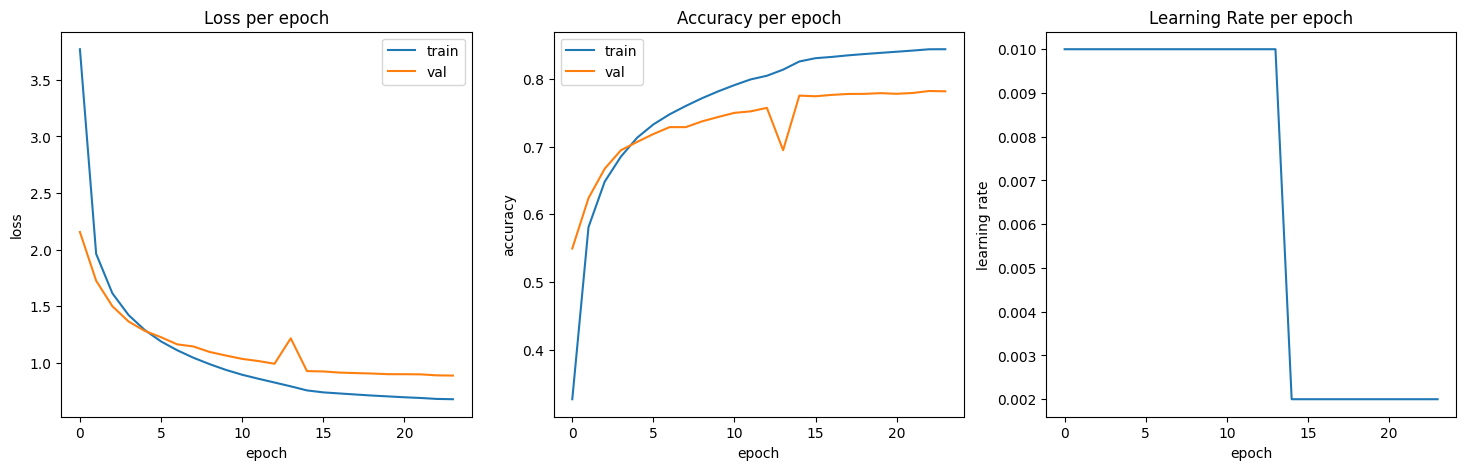

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(tot_history['loss'])
ax[0].plot(tot_history['val_loss'])
ax[0].set_title('Loss per epoch')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(['train', 'val'])

ax[1].plot(tot_history['accuracy'])
ax[1].plot(tot_history['val_accuracy'])
ax[1].set_title('Accuracy per epoch')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend(['train', 'val'])

ax[2].plot(tot_history['lr'])
ax[2].set_title('Learning Rate per epoch')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('learning rate')

fig.show()

In [ ]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

path = sys_font[-2]  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm.re

sys_font number: 17
['/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetyp

In [ ]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (10.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and dir

In [ ]:
plt.rcParams['font.family']

['NanumBarunGothic']

In [ ]:
class_names

'/content/drive/MyDrive/foodmodel/class_names.pkl'

1/1 [==============================] - 0s 85ms/step


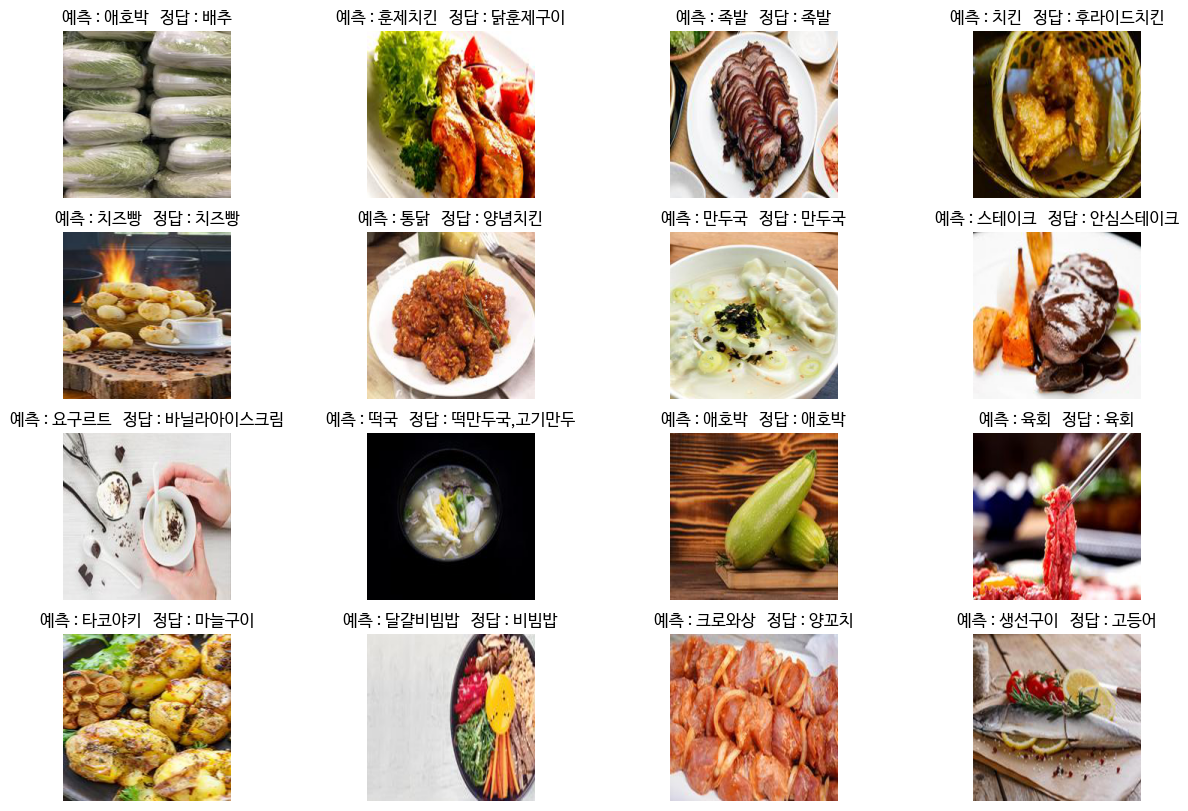

In [ ]:
import os
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
plt.rc('font', family='NanumBarunGothic')
def show_pred(sample_dir, labels, model, class_names):
  with open(class_names, 'rb')as f:
    class_names = pickle.load(f)

  with open(labels, 'rb')as f:
    labels = pickle.load(f)

  samples = []
  samplelist = os.listdir(sample_dir)

  for f in samplelist:
    if f.endswith('.jpg'):
      file_dir = os.path.join(sample_dir, f)
      samples.append(file_dir)

  fig, ax = plt.subplots(4, 4, figsize=(15,10))
  ax = ax.ravel()
  for i, image in enumerate(samples):
      img = Image.open(image)
      img = img.resize((224, 224))
      ax[i].imshow(img)
      ax[i].axis('off')
      img = np.array(img)
      img = np.expand_dims(img, axis=0)
      pred = model.predict(img)
      pred_class = np.argmax(pred)
      filename = image.split(os.sep)[-1]

      for key, value in class_names.items():
        if value == pred_class:
          ax[i].set_title(f'예측 : {key}   정답 : {labels[filename]}')

  return plt.show()
sample_dir = '/content/drive/MyDrive/Colab Notebooks/sample'
class_names = '/content/drive/MyDrive/foodmodel/class_names.pkl'
labels = '/content/drive/MyDrive/Colab Notebooks/sample/label.pkl'
model = load_model('/content/drive/MyDrive/foodmodel/efficientnet_foodsval2_model.h5')
show_pred(sample_dir, labels, model, class_names)



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input, EfficientNetB0
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

dir = '/content/foodval'
batch_size = 256
image_size = (224, 224)

data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15,
    rotation_range=10,
    shear_range=0.2,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = data_generator.flow_from_directory(
    dir,
    subset='training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = data_generator.flow_from_directory(
    dir,
    subset='validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 모델의 일부 레이어는 학습되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 251033 images belonging to 491 classes.
Found 44031 images belonging to 491 classes.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
from keras.callbacks import ModelCheckpoint
import os
model_type = 'efficientnet_foodsval_MK1'
save_dir = f'/content/drive/MyDrive/foodmodel'
model_dir = os.path.join(save_dir , f'{model_type}_model.h5')
history_dir = os.path.join(save_dir , f'{model_type}_history.pkl')
checkpoint_dir = os.path.join(save_dir , f'{model_type}_checkpoint.h5')
checkpoint = ModelCheckpoint(checkpoint_dir, save_best_only=True)

In [ ]:
history = model.fit(train_generator,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        epochs=10,
        callbacks=[checkpoint],
        use_multiprocessing=True,
        workers=num_cpus)

Epoch 1/10
980/980 [==============================] - 740s 737ms/step - loss: 3.1662 - accuracy: 0.3067 - val_loss: 2.0775 - val_accuracy: 0.4862
Epoch 2/10
980/980 [==============================] - 724s 728ms/step - loss: 2.3189 - accuracy: 0.4283 - val_loss: 1.8651 - val_accuracy: 0.5207
Epoch 3/10
980/980 [==============================] - 728s 736ms/step - loss: 2.1651 - accuracy: 0.4567 - val_loss: 1.7634 - val_accuracy: 0.5402
Epoch 4/10
980/980 [==============================] - 726s 733ms/step - loss: 2.0787 - accuracy: 0.4741 - val_loss: 1.7164 - val_accuracy: 0.5511
Epoch 5/10
980/980 [==============================] - 717s 723ms/step - loss: 2.0252 - accuracy: 0.4842 - val_loss: 1.6704 - val_accuracy: 0.5594
Epoch 6/10
980/980 [==============================] - 732s 740ms/step - loss: 1.9919 - accuracy: 0.4903 - val_loss: 1.6439 - val_accuracy: 0.5659
Epoch 7/10
980/980 [==============================] - 724s 731ms/step - loss: 1.9582 - accuracy: 0.4967 - val_loss: 1.6312 -

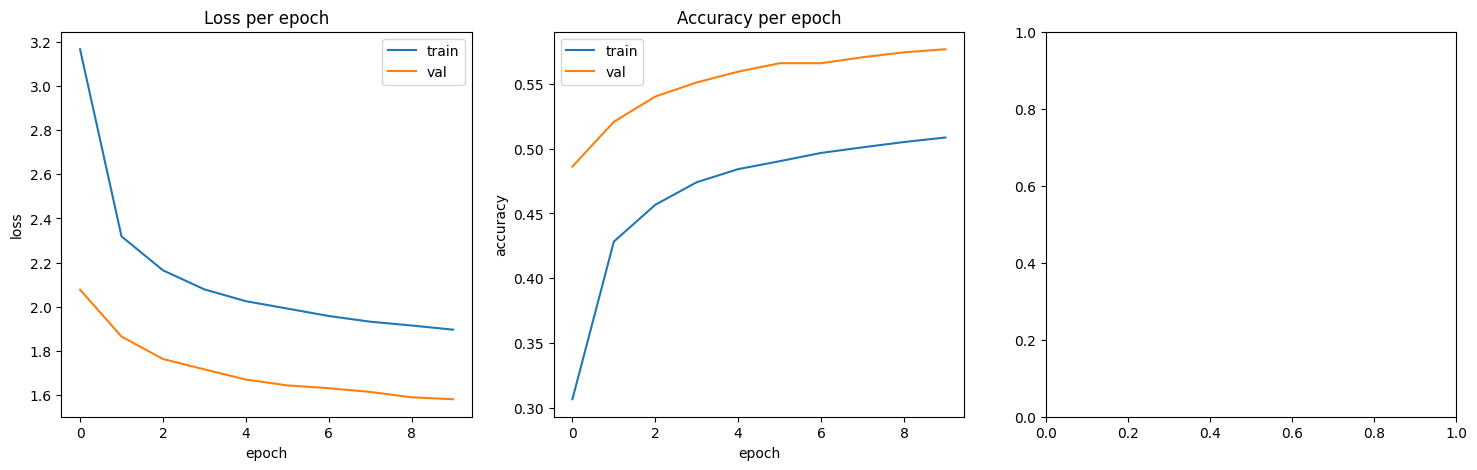

In [ ]:
tot_history = {'loss': [3.1662, 2.3189, 2.1651, 2.0787, 2.0252, 1.9919, 1.9582, 1.9324, 1.9151, 1.8963],
       'accuracy' : [0.3067, .4283, .4567, .4741, .4842, .4903, .4967, .5010, .5051, .5086],
       'val_loss' : [2.0775, 1.8651, 1.7634, 1.7164, 1.6704, 1.6439, 1.6312, 1.6143, 1.5899, 1.5813],
       'val_accuracy' : [.4862, .5207, .5402, .5511, .5594, .5659, .5659, .5705, .5743, .5767]}

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(tot_history['loss'])
ax[0].plot(tot_history['val_loss'])
ax[0].set_title('Loss per epoch')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(['train', 'val'])
ax[1].plot(tot_history['accuracy'])
ax[1].plot(tot_history['val_accuracy'])
ax[1].set_title('Accuracy per epoch')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend(['train', 'val'])

fig.show()

In [ ]:
from PIL import Image
from keras.models import load_model
from keras.applications.efficientnet import preprocess_input
import os
import numpy as np

samples_dir = '/content/drive/MyDrive/Colab Notebooks/sample'
samples = []
samples = [(os.path.join(samples_dir, sample)) for sample in os.listdir(samples_dir) if sample.endswith('.jpg')]
batch = []
images = []
for sample in sampl
    image = Image.open(sample)

    image = image.resize((224,224))
    org_Image = image
    image = np.array(image)
    batch.append(image)
    images.append(org_Image)
batch = np.array(batch)
batch = preprocess_input(batch)
model = load_model('/content/drive/MyDrive/foodmodel/efficientnet_foodsval2_model.h5')
preds = model.predict(batch)

1/1 [==============================] - 3s 3s/step


In [ ]:
from keras import backend as K
from keras.models import Model
import cv2
import tensorflow as tf

last_conv_layer = model.get_layer('top_conv')
heatmap_model = Model([model.input] , [last_conv_layer.output , model.output])
for index, image in enumerate(batch):
    org_Image = image
    image = np.expand_dims(image, axis=0)
    with tf.GradientTape() as gtape:

        conv_output, predictions = heatmap_model(image)

        # 가장 가능성이 높은 클래스에 대한 정보에서 loss 파악
        loss = predictions[:, np.argmax(predictions[0])]

        # top_conv의 특성 맵 출력에 대한 해당 클래스의 그래디언트
        grads = gtape.gradient(loss, conv_output)

        # 특성 맵 채널별 그래디언트 평균값이 담긴 벡터
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # 특성 맵의 출력
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # 0 ~ 1 사이의 값으로 정규화
    heatmap = np.maximum(heatmap, 0)

    max_heat = np.max(heatmap)

    if max_heat == 0:
        max_heat = 1e-10

    heatmap /= max_heat

    print('Heamap Shape : ', heatmap.shape)

    plt.matshow(heatmap[0]);
    # org_Image = Image.open(sample)
    # org_Image = org_Image.resize((224, 224))
    # org_Image = np.array(org_Image)
    height , width , channel = org_Image.shape

    # heatmap을 원본 이미지 사이즈에 맞춘다
    heatmap_Resized = cv2.resize(heatmap[0]  , (width , height))

    # 값을 0 ~ 255 사이 int 형으로 변경 // RGB 형식
    heatmap_Resized = np.uint8(255 * heatmap_Resized)

    # heatmap으로 변환
    heatmap_Resized = cv2.applyColorMap(heatmap_Resized , cv2.COLORMAP_JET)

    # 기존 이미지와 히트맵 이미지를 겹쳐서 그리기 위해
    superimposed_img = np.zeros((height , width , channel))

    for c in range(channel) :

        for i in range(height) :

            for j in range(width) :

                h = heatmap_Resized[i][j][c]
                v = org_Image[i][j][c]

                # 히트맵의 강도를 0.4로 설정
                superimposed_img[i][j][c] = h * 0.4 + v

    # cv2.imwrite(f'./heatmap_Result{index}.jpg' , superimposed_img)
    # result = cv2.imread('./heatmap_Result0.jpg')

    # plt.figure(figsize = (12 , 5))

    # plt.imshow(superimposed_img);

Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)
Heamap Shape :  (1, 7, 7)


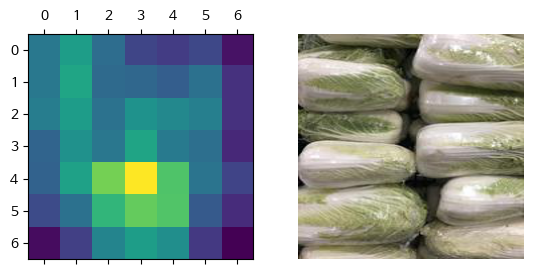

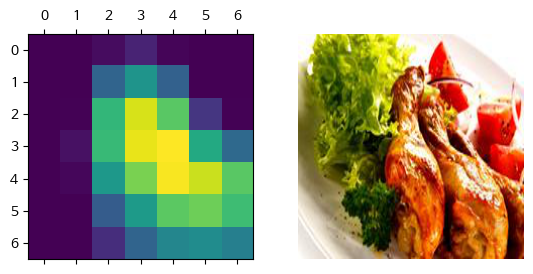

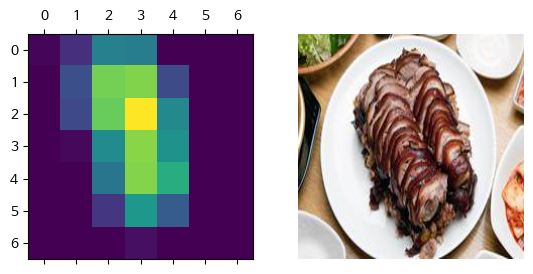

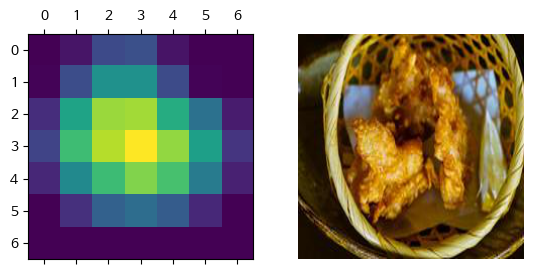

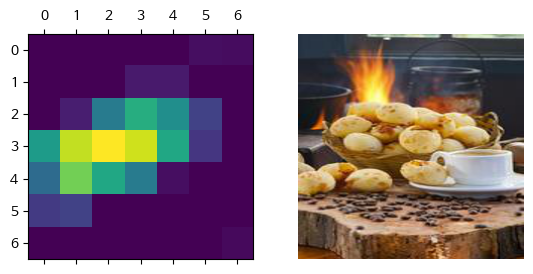

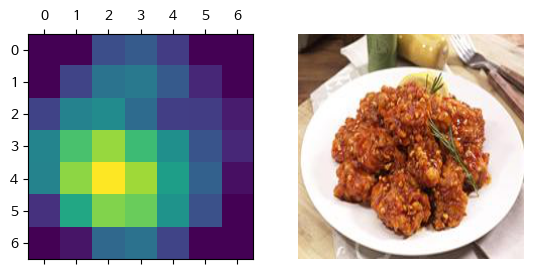

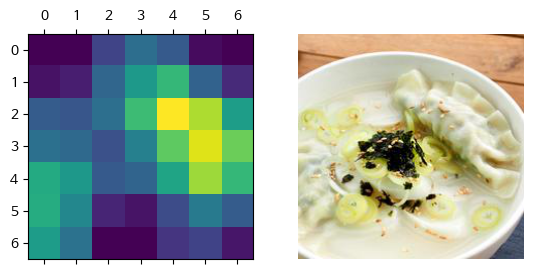

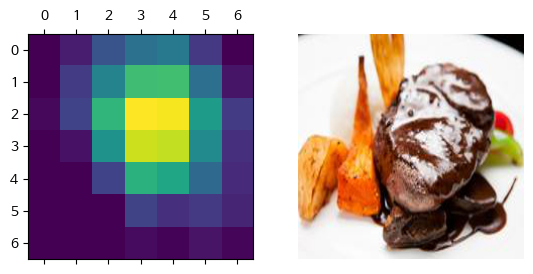

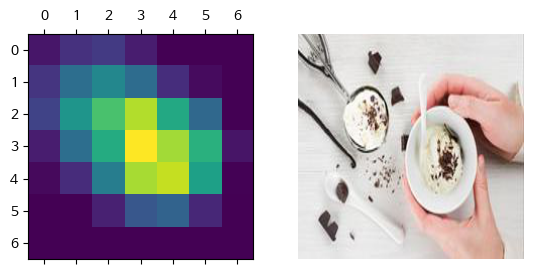

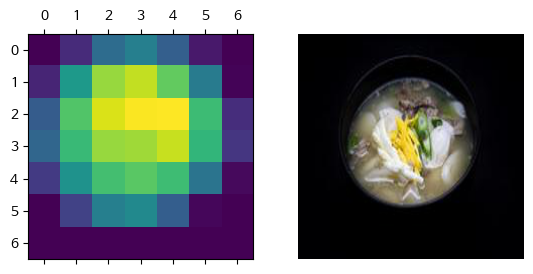

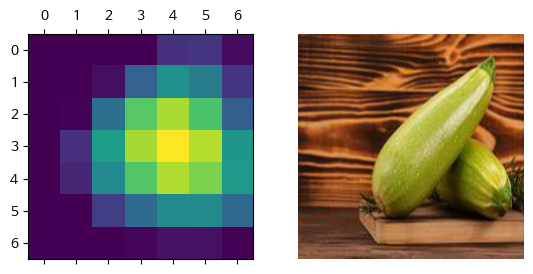

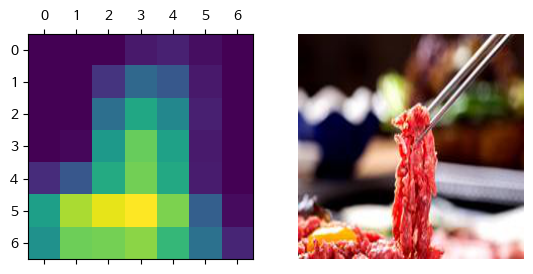

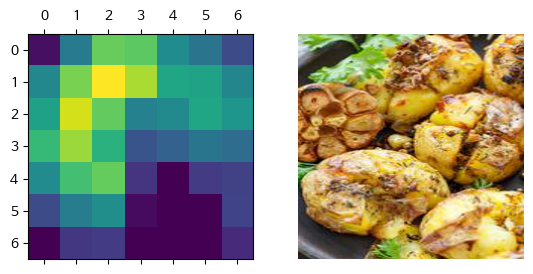

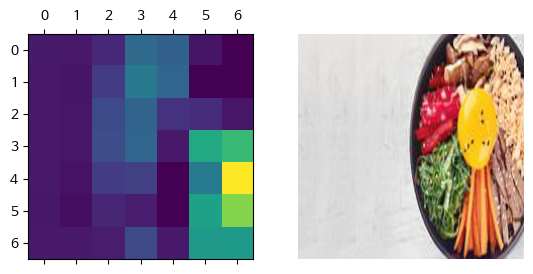

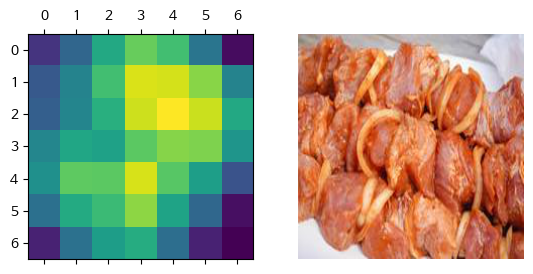

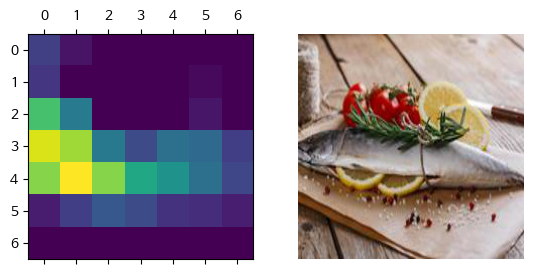

In [ ]:
last_conv_layer = model.get_layer('top_conv')
heatmap_model = Model([model.input] , [last_conv_layer.output , model.output])

for index, image in enumerate(batch):
    fig, ax = plt.subplots(1, 2)
    org_Image = image
    image = np.expand_dims(image, axis=0)
    with tf.GradientTape() as gtape:

        conv_output, predictions = heatmap_model(image)

        # 가장 가능성이 높은 클래스에 대한 정보에서 loss 파악
        loss = predictions[:, np.argmax(predictions[0])]

        # top_conv의 특성 맵 출력에 대한 해당 클래스의 그래디언트
        grads = gtape.gradient(loss, conv_output)

        # 특성 맵 채널별 그래디언트 평균값이 담긴 벡터
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # 특성 맵의 출력
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # 0 ~ 1 사이의 값으로 정규화
    heatmap = np.maximum(heatmap, 0)

    max_heat = np.max(heatmap)

    if max_heat == 0:
        max_heat = 1e-10

    heatmap /= max_heat

    print('Heamap Shape : ', heatmap.shape)

    ax[0].matshow(heatmap[0])
    ax[1].imshow(org_Image)
    plt.axis('off')

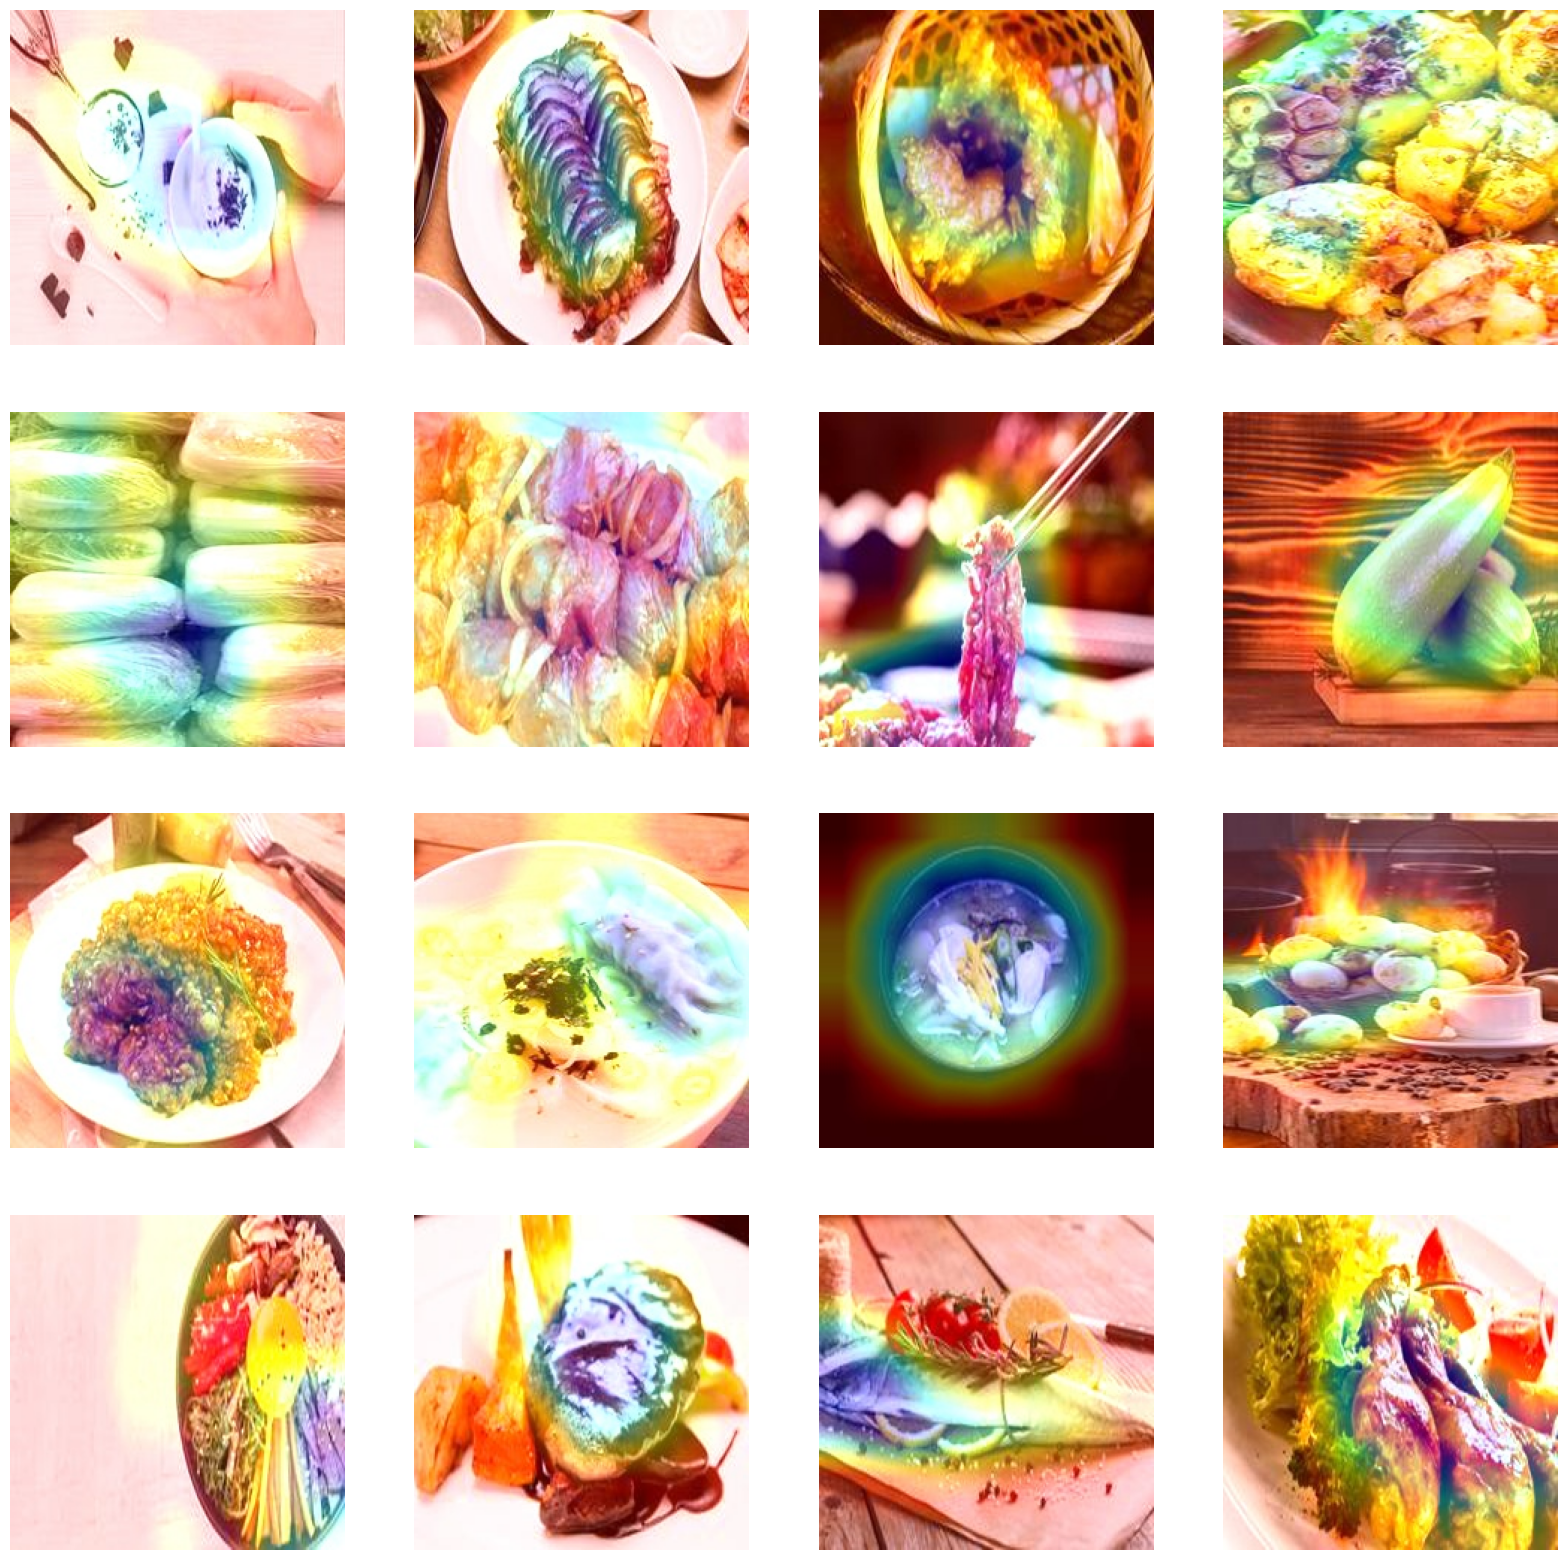

In [ ]:
import cv2
paths = [os.path.join('/content' , imagepath) for imagepath in os.listdir('/content') if imagepath.endswith('.jpg')]
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.2, hspace=0.2)

paths
for i,path in enumerate(paths):
  image = cv2.imread(path)
  # image = image.resize((224, 224))
  ax[i].imshow(image)
  ax[i].axis('off')
fig.show()


IndexError: ignored

1/1 [==============================] - 3s 3s/step
예측 : 피자   정답 : 피자


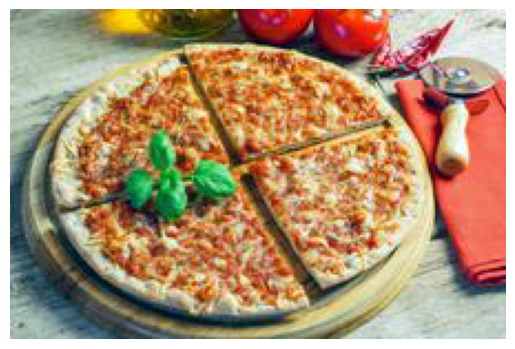

In [ ]:
import pickle
from keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 모델, label, 샘플 경로
with open('/content/drive/MyDrive/foodmodel/class_names.pkl', 'rb')as f:
  labels = pickle.load(f)
model = load_model('/content/drive/MyDrive/foodmodel/efficientnet_foodsval2_model.h5')
file_path = '/content/B020224XX_00024.jpg'

# 이미지 전처리 및 예측
image = Image.open(file_path)
image = image.resize((224, 224))
image = np.array(image)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)
pred = np.argmax(pred)

#결과 출력
for key, value in labels.items():
  # print(pred)
  if value == pred:
    print(f'예측 : {key}   정답 : 피자')
    plt.imshow(Image.open(file_path))
    plt.axis('off')
    plt.show()